# Dataset

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import requests
import datetime
import rasterio
import zipfile
import os
import csv
import snapista
import snappy
import pyroSAR
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from matplotlib.patches import Rectangle
from snappy import ProductIO, GPF, HashMap
from shapely.geometry import Point
from pathlib import Path
from pprint import pprint
from ost import Sentinel1Scene
#contextly

INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Incompatible GDAL 3.3.1 found on system. Internal GDAL 3.0.0 from distribution will be used.
INFO: org.esa.s2tbx.dataio.gdal.GDALVersion: Internal GDAL 3.0.0 set to be used by SNAP.
INFO: org.esa.snap.core.gpf.operators.tooladapter.ToolAdapterIO: Initializing external tool adapters
INFO: org.esa.snap.core.util.EngineVersionCheckActivator: Please check regularly for new updates for the best SNAP experience.
Currently installed 8.0, available is 10.0.0.
Please visit http://step.esa.int



In [2]:
file_path = 'earthquakes.parquet'

# Leggi il file .parquet
df = pd.read_parquet(file_path)
df = df[df['event_type_certainty'] == 'known']
df_lat_long = df[['latitude','longitude']]
print(df['longitude'])
#df['contain'] = df['description'].str['text'].apply(lambda x: 'Taiwan' in x)
#df_tai = df[df['contain']]
# Visualizza le prime righe del dataframe
#print(df_tai)


1       140.5898
2        94.8561
5       -83.4897
6        45.7501
7        45.7355
          ...   
2211    -81.7810
2213     28.3534
2216    138.2188
2219    121.8790
2225   -158.7077
Name: longitude, Length: 937, dtype: float64


In [11]:
dfp = pd.read_csv('df_all_earthquake.csv')
dfp1 = dfp[['latitude', 'longitude']].copy()
# Crea una colonna 'geometry' con punti geografici
# Crea una colonna 'geometry' con punti geografici
geometry = [Point(x,y) for x,y in zip(dfp1['longitude'], dfp1['latitude'])]

#gdf=gpd.GeoSeries(geometry, crs=crs)
gdf = gpd.GeoDataFrame(dfp1, geometry=geometry, crs='epsg:4326')



# Specifica il sistema di coordinate (ad esempio WGS84)
#gdf.set_crs(epsg=3857, inplace=True)

# Carica il dataset dei confini dei paesi
world = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

# Crea una figura e un asse
#fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Traccia i confini dei paesi
#world.boundary.plot(ax=ax, linewidth=1)


gdf.explore()

# Traccia i punti dei terremoti
#gdf.plot(ax=ax, color='red', markersize=5, alpha=0.5)

# Aggiungi il titolo e le etichette
#ax.set_title('Earthquake Locations with Known Certainty', fontsize=15)
#ax.set_xlabel('Longitude')
#ax.set_ylabel('Latitude')


# Mostra la mappa
#plt.show()

In [4]:
s = gpd.GeoSeries(
    [Point(1, 1), Point(2, 2), Point(3, 3)], crs="EPSG:3857"
)

In [8]:
df_filter = pd.read_csv('df_all_earthquake.csv')
df_filtered = df_filter[['resource_id', 'description', 'time', 'latitude', 'longitude', 'depth', 'magnitude', 'image_ids_before', 'image_ids_after']]  
print(df_filtered)

                resource_id  \
0    smi:ISC/evid=611622848   
1    smi:ISC/evid=616640738   
2    smi:ISC/evid=611634051   
3    smi:ISC/evid=611645479   
4    smi:ISC/evid=611835711   
..                      ...   
932  smi:ISC/evid=621204681   
933  smi:ISC/evid=621211187   
934  smi:ISC/evid=621229682   
935  smi:ISC/evid=621238060   
936  smi:ISC/evid=621244750   

                                           description  \
0    {'text': 'Southeast of Honshu', 'type': 'Flinn...   
1    {'text': 'Myanmar-India border region', 'type'...   
2    {'text': 'North of Honduras', 'type': 'Flinn-E...   
3    {'text': 'Iran-Iraq border region', 'type': 'F...   
4    {'text': 'Iran-Iraq border region', 'type': 'F...   
..                                                 ...   
932  {'text': 'North of Honduras', 'type': 'Flinn-E...   
933  {'text': 'Eastern Mediterranean Sea', 'type': ...   
934  {'text': 'Southeast of Honshu', 'type': 'Flinn...   
935  {'text': 'Taiwan', 'type': 'Flinn-Engdahl 

In [9]:
#Filtra e stampa solo le righe dove 'image_ids_before' e 'image_ids_after' non è vuoto e non sono liste vuote
df_earthquake = df_filtered[
    df_filtered['image_ids_before'].notna() & df_filtered['image_ids_after'].notna() & 
    df_filtered['image_ids_before'].apply(lambda x: bool(x)) & df_filtered['image_ids_after'].apply(lambda x: bool(x))
]

In [10]:
#filtro il dataset e creo un nuovo file csv
#df_earthquake = pd.read_csv('df_images_earthquakes.csv')
print(df_earthquake)
print(df_earthquake['image_ids_before'].iloc[0])

                resource_id  \
3    smi:ISC/evid=611645479   
4    smi:ISC/evid=611835711   
8    smi:ISC/evid=611835770   
20   smi:ISC/evid=611835901   
21   smi:ISC/evid=616570807   
..                      ...   
923  smi:ISC/evid=621126624   
925  smi:ISC/evid=621131627   
929  smi:ISC/evid=626703581   
931  smi:ISC/evid=621146229   
933  smi:ISC/evid=621211187   

                                           description  \
3    {'text': 'Iran-Iraq border region', 'type': 'F...   
4    {'text': 'Iran-Iraq border region', 'type': 'F...   
8    {'text': 'Gulf of California', 'type': 'Flinn-...   
20   {'text': 'Taiwan', 'type': 'Flinn-Engdahl regi...   
21   {'text': 'Taiwan', 'type': 'Flinn-Engdahl regi...   
..                                                 ...   
923  {'text': 'Pakistan', 'type': 'Flinn-Engdahl re...   
925  {'text': 'Myanmar', 'type': 'Flinn-Engdahl reg...   
929  {'text': 'Kuril Islands', 'type': 'Flinn-Engda...   
931  {'text': 'Crete', 'type': 'Flinn-Engdahl r

In [11]:
df_earthquake = pd.read_csv('df_images_eartquake.csv')
final_df = df_earthquake[['description' ,'time', 'latitude','longitude', 'depth','magnitude', 'image_ids_before', 'image_ids_after']].copy()
final_df['image_ids_before'] = final_df['image_ids_before'].astype(str)
final_df['image_ids_after'] = final_df['image_ids_after'].astype(str)

# Visualizza il risultato
print(final_df['image_ids_before'].iloc[3])

  S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8  


In [12]:
# Crea una colonna 'geometry' con punti geografici
geometry = [Point(xy) for xy in zip(final_df['longitude'], final_df['latitude'])]
gdf = gpd.GeoDataFrame(final_df, geometry=geometry)

# Specifica il sistema di coordinate (ad esempio WGS84)
gdf.set_crs(epsg=4326, inplace=True)

# Carica il dataset dei confini dei paesi
world = gpd.read_file('ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp')

# Crea una figura e un asse
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Traccia i confini dei paesi
world.boundary.plot(ax=ax, linewidth=1)

# Traccia i punti dei terremoti
gdf.plot(ax=ax, color='red', markersize=5, alpha=0.5)

# Aggiungi il titolo e le etichette
ax.set_title('Earthquake Locations with Images SLC', fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Mostra la mappa
plt.show()

CRSError: Invalid projection: EPSG:4326: (Internal Proj Error: proj_create: no database context specified)

# Download Images

In [13]:
# these imports we need to handle the folders, independent of the OS
from pathlib import Path
from pprint import pprint

# this is the Sentinel1Scene class, that basically handles all the workflow from beginning to the end
from ost import Sentinel1Scene

#1
# very first IW (VV/VH) S1 image available over Istanbul/Turkey 
# IW scene (dual-polarised VV/VH)

scene_id1 = final_df['image_ids_before'].iloc[0]

scene_id2 = final_df['image_ids_after'].iloc[0]

#6-8-9-10-11-12


# other scenes with different scene types to process (uncomment)
# IW scene (dual-polarised HH/HV) over Norway/Spitzbergen
# scene_id = 'S1B_IW_GRDH_1SDH_20200325T150411_20200325T150436_020850_02789D_2B85'  


print('scene_id1',scene_id1)
print('scene_id2',scene_id2)

#---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180106T025411_20180106T025439_020028_0221F4_0110')

# create an S1Scene instance
s2 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180118T025410_20180118T025438_020203_022783_6334')
                    
# print summarising infos about the scene
s1.info()
s2.info()

# Use the index of the row as the identifier
row_index = final_df.index[1]
image_dir = "Image" + str(row_index)
print(image_dir)

# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', image_dir)
new_path.mkdir(parents=True, exist_ok=True)

s1.download(new_path)
s2.download(new_path)

In [ ]:
#2
# very first IW (VV/VH) S1 image available over Istanbul/Turkey 
# IW scene (dual-polarised VV/VH)

scene_id1 = final_df['image_ids_before'].iloc[1]

scene_id2 = final_df['image_ids_after'].iloc[1]

print('scene_id1',scene_id1)
print('scene_id2',scene_id2)

In [ ]:
# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8')

# create an S1Scene instance
s2 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180205T215202_20180205T215231_020477_023046_97B4')
                    
# print summarising infos about the scene
s1.info()
s2.info()

# Use the index of the row as the identifier
row_index = final_df.index[2]
image_dir = "Image" + str(row_index)
print(image_dir)

# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', image_dir)
new_path.mkdir(parents=True, exist_ok=True)

s1.download(new_path)
s2.download(new_path)

# 4
# very first IW (VV/VH) S1 image available over Istanbul/Turkey 
# IW scene (dual-polarised VV/VH)

scene_id1 = final_df['image_ids_before'].iloc[3]

scene_id2 = final_df['image_ids_after'].iloc[3]

print('scene_id1',scene_id1)
print('scene_id2',scene_id2)

# ---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8')

# create an S1Scene instance
s2 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180205T215202_20180205T215231_020477_023046_97B4')
                    
# print summarising infos about the scene
s1.info()
s2.info()

# Use the index of the row as the identifier
row_index = final_df.index[4]
image_dir = "Image" + str(row_index)
print(image_dir)

# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', image_dir)
new_path.mkdir(parents=True, exist_ok=True)

s1.download(new_path)
s2.download(new_path)

In [30]:
#5 uguale alla 4
# very first IW (VV/VH) S1 image available over Istanbul/Turkey 
# IW scene (dual-polarised VV/VH)

scene_id1 = final_df['image_ids_before'].iloc[4]
scene_id2 = final_df['image_ids_after'].iloc[4]

print('scene_id1',scene_id1)
print('scene_id2',scene_id2)

scene_id1   S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8  
scene_id2   S1A_IW_SLC__1SDV_20180205T215202_20180205T215231_020477_023046_97B4  


In [31]:
#---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8')

# create an S1Scene instance
s2 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180205T215202_20180205T215231_020477_023046_97B4')
                    
# print summarising infos about the scene
s1.info()
s2.info()

# Use the index of the row as the identifier
row_index = final_df.index[5]
image_dir = "Image" + str(row_index) + "uguale_alla_4"
print(image_dir)

# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', image_dir)
new_path.mkdir(parents=True, exist_ok=True)

s1.download(new_path)
s2.download(new_path)

INFO:ost.s1.s1scene:One or more of your scenes need to be downloaded.


 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180203
 Start Time:              100056
 Stop Time:               100124
 Absolute Orbit:          020441
 Relative Orbit:          69
 -------------------------------------------------
 -------------------------------------------------
 Scene Information:
 Scene Identifier:        S1A_IW_SLC__1SDV_20180205T215202_20180205T215231_020477_023046_97B4
 Satellite:               Sentinel-1A
 Acquisition Mode:        Interferometric Wide Swath
 Processing Level:        1
 Product Type:            Single-Look Complex (SLC)
 Acquisition Date:        20180205
 Start Time:              215202
 Stop Time:               215231
 Absolute Orb

 Type 1, 2, 3, or 4:  2


 If you do not have a ASF/NASA Earthdata user account go to: https://search.asf.alaska.edu/ and register


 Your ASF/NASA Earthdata Username: Elenabucco
 Your ASF/NASA Earthdata Password: ········


INFO:ost.helpers.asf:Downloading scene to: /data3/ebuccoliero/Images/Image5uguale_alla_4/SAR/SLC/2018/02/03/S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8.zip


 INFO (17:24:31): Downloading scene to: /data3/ebuccoliero/Images/Image5uguale_alla_4/SAR/SLC/2018/02/03/S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8.zip


 INFO: Downloading : 4.65GB [06:45, 11.5MB/s]                                                                                                                         
INFO:ost.helpers.asf:S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8.zip passed the zip test.


 INFO (17:32:08): S1A_IW_SLC__1SDV_20180203T100056_20180203T100124_020441_022F24_61A8.zip passed the zip test.


INFO:ost.helpers.asf:All products are downloaded.


 INFO (17:32:08): All products are downloaded.


INFO:ost.s1.s1scene:One or more of your scenes need to be downloaded.


 INFO (17:32:08): One or more of your scenes need to be downloaded.
 Select the server from where you want to download:
 (1) Copernicus Apihub (ESA, rolling archive)
 (2) Alaska Satellite Facility (NASA, full archive)
 (3) PEPS (CNES, 1 year rolling archive)
 (4) ONDA DIAS (ONDA DIAS full archive for SLC - or GRD from 30 June 2019)


 Type 1, 2, 3, or 4:  2


 If you do not have a ASF/NASA Earthdata user account go to: https://search.asf.alaska.edu/ and register


 Your ASF/NASA Earthdata Username: Elenabucco
 Your ASF/NASA Earthdata Password: ········


INFO:ost.helpers.asf:Downloading scene to: /data3/ebuccoliero/Images/Image5uguale_alla_4/SAR/SLC/2018/02/05/S1A_IW_SLC__1SDV_20180205T215202_20180205T215231_020477_023046_97B4.zip


 INFO (17:33:06): Downloading scene to: /data3/ebuccoliero/Images/Image5uguale_alla_4/SAR/SLC/2018/02/05/S1A_IW_SLC__1SDV_20180205T215202_20180205T215231_020477_023046_97B4.zip


 INFO: Downloading : 4.81GB [07:01, 11.4MB/s]                          
INFO:ost.helpers.asf:S1A_IW_SLC__1SDV_20180205T215202_20180205T215231_020477_023046_97B4.zip passed the zip test.


 INFO (17:41:01): S1A_IW_SLC__1SDV_20180205T215202_20180205T215231_020477_023046_97B4.zip passed the zip test.


INFO:ost.helpers.asf:All products are downloaded.


 INFO (17:41:01): All products are downloaded.


# 7
# very first IW (VV/VH) S1 image available over Istanbul/Turkey 
# IW scene (dual-polarised VV/VH)

scene_id1 = final_df['image_ids_before'].iloc[6]
scene_id2 = final_df['image_ids_after'].iloc[6]

print('scene_id1',scene_id1)
print('scene_id2',scene_id2)

#---------------------------------------------------

# create an S1Scene instance
s1 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180323T132236_20180323T132303_021143_024571_0007')

# create an S1Scene instance
s2 = Sentinel1Scene('S1A_IW_SLC__1SDV_20180330T131421_20180330T131448_021245_02489D_9078')
                    
# print summarising infos about the scene
s1.info()
s2.info()

# Use the index of the row as the identifier
row_index = final_df.index[7]
image_dir = "Image" + str(row_index)
print(image_dir)

# Get the current path
current_path = Path.cwd()
new_path = current_path.joinpath('Images', image_dir)
new_path.mkdir(parents=True, exist_ok=True)

s1.download(new_path)
s2.download(new_path)

# Visualizzare interferogrammi

In [10]:
import pyroSAR
import snapista
from pyroSAR import identify
import os

from pyroSAR.snap import geocode
from snapista import Graph

In [11]:
#Lettura Immagini con PyroSAR
name1 = 'Images/Image3/SAR/SLC/2018/01/14/S1A_IW_SLC__1SDV_20180114T132118_20180114T132145_020151_0225F3_53F5.zip'
scene3_1 = identify(name1)
print("SCENE 3_1:\n",scene3_1)
#print(scene3_1.meta)

SCENE 3_1:
 pyroSAR ID object of type SAFE
acquisition_mode: IW
coordinates: [(-109.989349, 25.679638), (-112.499832, 26.097631), (-112.182777, 27.728321), (-109.634277, 27.313227)]
cycleNumber: 129
frameNumber: 140787
lines: 40761
orbit: D
orbitNumber_abs: 20151
orbitNumber_rel: 129
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 72616
sensor: S1A
spacing: (2.329562, 13.96392)
start: 20180114T132118
stop: 20180114T132145


In [12]:
name2 = 'Images/Image3/SAR/SLC/2018/01/26/S1A_IW_SLC__1SDV_20180126T132118_20180126T132145_020326_022B7D_D29E.zip'
scene3_2 = identify(name2)
print("SCENE 3_2 :\n",scene3_2)

SCENE 3_2 :
 pyroSAR ID object of type SAFE
acquisition_mode: IW
coordinates: [(-109.988632, 25.679216), (-112.499077, 26.097261), (-112.181953, 27.728075), (-109.633492, 27.312927)]
cycleNumber: 130
frameNumber: 142205
lines: 40761
orbit: D
orbitNumber_abs: 20326
orbitNumber_rel: 129
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 72616
sensor: S1A
spacing: (2.329562, 13.96395)
start: 20180126T132118
stop: 20180126T132145


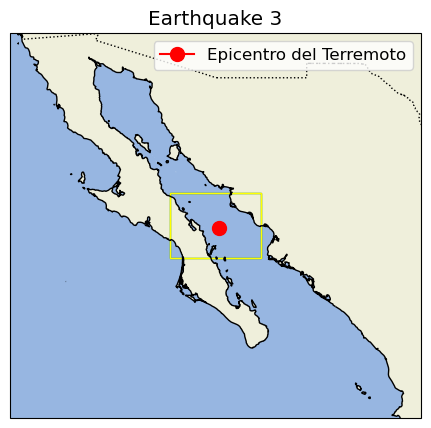

In [15]:
#Earthquake index 3

# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = [(-109.989349, 25.679638), (-112.499832, 26.097631), (-112.182777, 27.728321), (-109.634277, 27.313227)]
bbox_coords2 =[(-109.988632, 25.679216), (-112.499077, 26.097261), (-112.181953, 27.728075), (-109.633492, 27.312927)]
# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])


xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])


# Coordinate dell'epicentro del terremoto
epicenter_lat = final_df['latitude'].iloc[2]
epicenter_lon = final_df['longitude'].iloc[2]
#print(epicenter_lat, epicenter_lon)

# Creare una figura e una proiezione cartografica
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Aggiungere caratteristiche della terra
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Aggiungere il rettangolo del bbox
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1,
                 linewidth=1, edgecolor='green', facecolor='none')

# Aggiungere il rettangolo del bbox
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2,
                 linewidth=1, edgecolor='yellow', facecolor='none')


ax.add_patch(rect1)
ax.add_patch(rect2)

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

#add legend
plt.legend()

plt.title('Earthquake 3')

# Visualizzare la mappa
plt.show()


In [1]:
import zipfile
import os

def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Example paths
zip_path_pre = './Images/Image3/SAR/SLC/2018/01/14/S1A_IW_SLC__1SDV_20180114T132118_20180114T132145_020151_0225F3_53F5.zip'
zip_path_post = './Images/Image3/SAR/SLC/2018/01/26/S1A_IW_SLC__1SDV_20180126T132118_20180126T132145_020326_022B7D_D29E.zip'

# Define extraction directories
extract_to_pre = './Images/Image3/SAR/SLC/2018/01/14/'
extract_to_post = './Images/Image3/SAR/SLC/2018/01/26/'

# Extract the content
extract_zip(zip_path_pre, extract_to_pre)
extract_zip(zip_path_post, extract_to_post)


In [ ]:
#PROVA1

In [ ]:
import snappy
from snappy import ProductIO, GPF, HashMap, jpy

# Define paths to your Sentinel-1 products
slc_image_1 = 'Images/Image3/SAR/SLC/2018/01/14/S1A_IW_SLC__1SDV_20180114T132118_20180114T132145_020151_0225F3_53F5.zip'
slc_image_2 = 'Images/Image3/SAR/SLC/2018/01/26/S1A_IW_SLC__1SDV_20180126T132118_20180126T132145_020326_022B7D_D29E.zip'

# Load the SLC images from .zip files
product1 = ProductIO.readProduct(slc_image_1)
product2 = ProductIO.readProduct(slc_image_2)

# Create a dictionary of parameters for TOPSAR-Split
split_params = HashMap()
split_params.put('subswath', 'IW1')  # Choose the relevant subswath (e.g., IW1, IW2, IW3)
split_params.put('selectedPolarisations', 'VV')  # Choose the polarization (VV, VH, HH, HV)
split_params.put('firstBurstIndex', 2)  # Define burst range if needed
split_params.put('lastBurstIndex', 8)  # -1 means until the last burst

# Apply TOPSAR-Split to both products
split_product1 = GPF.createProduct('TOPSAR-Split', split_params, product1)
split_product2 = GPF.createProduct('TOPSAR-Split', split_params, product2)

# Apply the precise orbit file (Sentinel-Precise)
orbit_params = HashMap()
orbit_params.put('orbitType', 'Sentinel Precise (Auto Download)')  # Set to auto-download the precise orbit file
orbit_params.put('polyDegree', 3)

# Apply Orbit File to both split products
orbit_corrected_product1 = GPF.createProduct('Apply-Orbit-File', orbit_params, split_product1)
orbit_corrected_product2 = GPF.createProduct('Apply-Orbit-File', orbit_params, split_product2)

# Perform Back-Geocoding
back_geo_params = HashMap()
back_geo_params.put('demName', 'SRTM 1Sec HGT')
back_geo_params.put('resamplingType', 'BILINEAR_INTERPOLATION')
back_geo_params.put('maskOutAreaWithoutElevation', True)

try:
    back_geocoded_product = GPF.createProduct('Back-Geocoding', back_geo_params, [orbit_corrected_product1, orbit_corrected_product2])
    print("Back-Geocoding completed successfully.")
except Exception as e:
    print("Error during Back-Geocoding:", e)
    exit()

# Interferogram formation parameters
interferogram_params = HashMap()
interferogram_params.put('subtractFlatEarthPhase', True)
interferogram_params.put('srpPolynomialDegree', 5)
interferogram_params.put('srpNumberPoints', 501)
interferogram_params.put('orbitDegree', 3)

# Generate the interferogram
try:
    interferogram = GPF.createProduct('Interferogram', interferogram_params, back_geocoded_product)
    print("Interferogram generated successfully.")
except Exception as e:
    print("Error during interferogram generation:", e)
    exit()

# Extract the phase and intensity bands
band_names = interferogram.getBandNames()
print("Bands available in the interferogram product:", list(band_names))

# Get the phase band (usually something like 'Phase_ifg_VV')
phase_band_name = [name for name in band_names if 'Phase' in name][0]
intensity_band_name = [name for name in band_names if 'Intensity' in name][0]

# Create subsets for phase and intensity
subset_params = HashMap()
subset_params.put('sourceBands', phase_band_name)
phase_product = GPF.createProduct('Subset', subset_params, interferogram)

subset_params.put('sourceBands', intensity_band_name)
intensity_product = GPF.createProduct('Subset', subset_params, interferogram)

# Save the phase and intensity products to .dim files
phase_output_file = 'Images/Image3/phase_product.dim'
intensity_output_file = 'Images/Image3/intensity_product.dim'

try:
    ProductIO.writeProduct(phase_product, phase_output_file, 'BEAM-DIMAP')
    print(f"Phase product has been saved to {phase_output_file}")
except Exception as e:
    print("Error saving the phase product:", e)

try:
    ProductIO.writeProduct(intensity_product, intensity_output_file, 'BEAM-DIMAP')
    print(f"Intensity product has been saved to {intensity_output_file}")
except Exception as e:
    print("Error saving the intensity product:", e)



Back-Geocoding completed successfully.
Interferogram generated successfully.
100% done.

100% done.

100% done.

100% done.

100% done.

100% done.
Bands available in the interferogram product: 

In [ ]:
#PROVA2

In [ ]:
from snappy import ProductIO, GPF, HashMap

# Load the master and slave products
master = ProductIO.readProduct('Images/Image3/SAR/SLC/2018/01/14/S1A_IW_SLC__1SDV_20180114T132118_20180114T132145_020151_0225F3_53F5.zip')
slave = ProductIO.readProduct('Images/Image3/SAR/SLC/2018/01/26/S1A_IW_SLC__1SDV_20180126T132118_20180126T132145_020326_022B7D_D29E.zip')

# Step 1: Coregistration using Back-Geocoding
params_backgeo = HashMap()
params_backgeo.put('demName', 'SRTM 3Sec')
params_backgeo.put('resamplingType', 'BILINEAR_INTERPOLATION')

coregistered = GPF.createProduct('Back-Geocoding', params_backgeo, [master, slave])

# Step 2: Create the interferogram
params_interferogram = HashMap()
params_interferogram.put('subtractFlatEarthPhase', True)
params_interferogram.put('srpPolynomialDegree', 5)
params_interferogram.put('srpNumberPoints', 501)
params_interferogram.put('orbitDegree', 3)
params_interferogram.put('includeCoherence', True)

interferogram = GPF.createProduct('Interferogram', params_interferogram, coregistered)

# Step 3: Save the result to check if the interferogram is created
ProductIO.writeProduct(interferogram, 'Images/Image3/interferogram', 'BEAM-DIMAP')


In [13]:
name6 = 'Images/Image6/SAR/SLC/2018/02/15/S1A_IW_SLC__1SDV_20180215T121822_20180215T121848_020617_0234C5_C1A3.zip'
scene6_1 = identify(name6)
print("SCENE 6_1:\n",scene6_1)

SCENE 6_1:
 pyroSAR ID object of type SAFE
acquisition_mode: IW
coordinates: [(-95.754082, 15.227077), (-98.04467, 15.658874), (-97.737671, 17.234777), (-95.427803, 16.806658)]
cycleNumber: 132
frameNumber: 144581
lines: 38984
orbit: D
orbitNumber_abs: 20617
orbitNumber_rel: 70
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 68700
sensor: S1A
spacing: (2.329562, 13.99679)
start: 20180215T121822
stop: 20180215T121848


In [29]:
name6= 'Images/Image6/SAR/SLC/2018/02/20/S1A_IW_SLC__1SDV_20180220T122625_20180220T122651_020690_023710_6CEF.zip'
scene6_2 = identify(name6)
print(scene6_2)

pyroSAR ID object of type SAFE
acquisition_mode: IW
coordinates: [(-97.672455, 15.849737), (-99.979301, 16.281841), (-99.672867, 17.856546), (-97.345818, 17.428074)]
cycleNumber: 132
frameNumber: 145168
lines: 39036
orbit: D
orbitNumber_abs: 20690
orbitNumber_rel: 143
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 69235
sensor: S1A
spacing: (2.329562, 13.9933)
start: 20180220T122625
stop: 20180220T122651


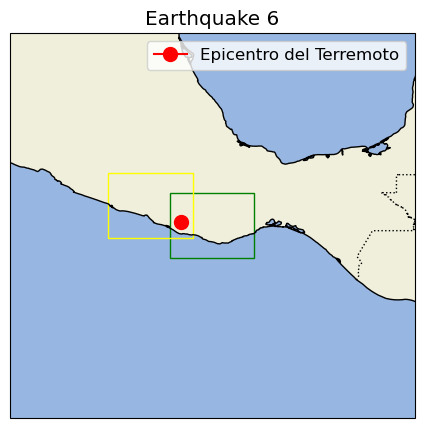

In [30]:
#Earthquake index 6

# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = [(-95.754082, 15.227077), (-98.04467, 15.658874), (-97.737671, 17.234777), (-95.427803, 16.806658)]
bbox_coords2 = [(-97.672455, 15.849737), (-99.979301, 16.281841), (-99.672867, 17.856546), (-97.345818, 17.428074)]

# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])


xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])


# Coordinate dell'epicentro del terremoto
epicenter_lat = final_df['latitude'].iloc[5]
epicenter_lon = final_df['longitude'].iloc[5]
#print(epicenter_lat, epicenter_lon)

# Creare una figura e una proiezione cartografica
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Aggiungere caratteristiche della terra
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Aggiungere il rettangolo del bbox
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1,
                 linewidth=1, edgecolor='green', facecolor='none')

# Aggiungere il rettangolo del bbox
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2,
                 linewidth=1, edgecolor='yellow', facecolor='none')


ax.add_patch(rect1)
ax.add_patch(rect2)

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

#add legend
plt.legend()

plt.title('Earthquake 6')

# Visualizzare la mappa
plt.show()


In [37]:
name= 'Images/Image8/SAR/SLC/2018/04/02/S1A_IW_SLC__1SDV_20180402T002208_20180402T002235_021281_0249BF_1B5D.zip'
scene8_1 = identify(name)
print(scene8_1)

pyroSAR ID object of type SAFE
acquisition_mode: IW
coordinates: [(-94.101212, 14.520425), (-91.780869, 14.961207), (-91.462486, 13.335601), (-93.765884, 12.890775)]
cycleNumber: 136
frameNumber: 149951
lines: 40527
orbit: A
orbitNumber_abs: 21281
orbitNumber_rel: 34
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 71723
sensor: S1A
spacing: (2.329562, 13.9997)
start: 20180402T002208
stop: 20180402T002235


In [38]:
name= 'Images/Image8/SAR/SLC/2018/04/09/S1A_IW_SLC__1SDV_20180409T001347_20180409T001414_021383_024CFC_907A.zip'
scene8_2 = identify(name)
print(scene8_2)

pyroSAR ID object of type SAFE
acquisition_mode: IW
coordinates: [(-91.953568, 14.080097), (-89.64016, 14.521609), (-89.321205, 12.895471), (-91.618279, 12.449882)]
cycleNumber: 136
frameNumber: 150780
lines: 40527
orbit: A
orbitNumber_abs: 21383
orbitNumber_rel: 136
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 71475
sensor: S1A
spacing: (2.329562, 14.00087)
start: 20180409T001347
stop: 20180409T001414


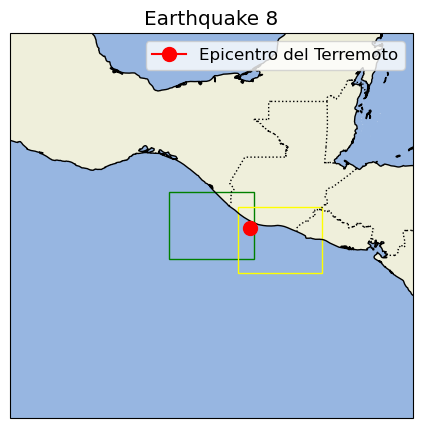

In [39]:
#Earthquake index 8

# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = [(-94.101212, 14.520425), (-91.780869, 14.961207), (-91.462486, 13.335601), (-93.765884, 12.890775)]
bbox_coords2 = [(-91.953568, 14.080097), (-89.64016, 14.521609), (-89.321205, 12.895471), (-91.618279, 12.449882)]
# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])


xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])


# Coordinate dell'epicentro del terremoto
epicenter_lat = final_df['latitude'].iloc[7]
epicenter_lon = final_df['longitude'].iloc[7]
#print(epicenter_lat, epicenter_lon)

# Creare una figura e una proiezione cartografica
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Aggiungere caratteristiche della terra
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Aggiungere il rettangolo del bbox
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1,
                 linewidth=1, edgecolor='green', facecolor='none')

# Aggiungere il rettangolo del bbox
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2,
                 linewidth=1, edgecolor='yellow', facecolor='none')


ax.add_patch(rect1)
ax.add_patch(rect2)

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

#add legend
plt.legend()

plt.title('Earthquake 8')

# Visualizzare la mappa
plt.show()


In [40]:
name9= 'Images/Image9/SAR/SLC/2018/05/02/S1A_IW_SLC__1SDV_20180502T213827_20180502T213857_021731_0257E3_3A4C.zip'
scene9_1 = identify(name9)
print(scene9_1)

pyroSAR ID object of type SAFE
acquisition_mode: IW
coordinates: [(123.949837, 13.120376), (121.65686, 13.562201), (122.009087, 15.361502), (124.321205, 14.924092)]
cycleNumber: 138
frameNumber: 153571
lines: 45030
orbit: D
orbitNumber_abs: 21731
orbitNumber_rel: 134
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 70743
sensor: S1A
spacing: (2.329562, 14.0)
start: 20180502T213827
stop: 20180502T213857


In [41]:
name= 'Images/Image9/SAR/SLC/2018/05/09/S1A_IW_SLC__1SDV_20180509T213021_20180509T213051_021833_025B23_1333.zip'
scene9_2 = identify(name)
print(scene9_2)

pyroSAR ID object of type SAFE
acquisition_mode: IW
coordinates: [(125.912491, 12.664123), (123.623993, 13.107099), (123.976746, 14.906697), (126.283684, 14.46818)]
cycleNumber: 139
frameNumber: 154403
lines: 45030
orbit: D
orbitNumber_abs: 21833
orbitNumber_rel: 61
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 70743
sensor: S1A
spacing: (2.329562, 14.00118)
start: 20180509T213021
stop: 20180509T213051


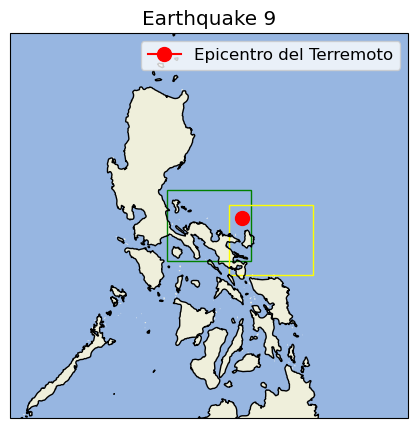

In [42]:
#Earthquake index 9

# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = [(123.949837, 13.120376), (121.65686, 13.562201), (122.009087, 15.361502), (124.321205, 14.924092)]
bbox_coords2 = [(125.912491, 12.664123), (123.623993, 13.107099), (123.976746, 14.906697), (126.283684, 14.46818)]
# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])


xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])


# Coordinate dell'epicentro del terremoto
epicenter_lat = final_df['latitude'].iloc[8]
epicenter_lon = final_df['longitude'].iloc[8]
#print(epicenter_lat, epicenter_lon)

# Creare una figura e una proiezione cartografica
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Aggiungere caratteristiche della terra
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Aggiungere il rettangolo del bbox
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1,
                 linewidth=1, edgecolor='green', facecolor='none')

# Aggiungere il rettangolo del bbox
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2,
                 linewidth=1, edgecolor='yellow', facecolor='none')


ax.add_patch(rect1)
ax.add_patch(rect2)

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

#add legend
plt.legend()
plt.title('Earthquake 9')

# Visualizzare la mappa
plt.show()


In [43]:
name= 'Images/Image10/SAR/SLC/2018/05/05/S1A_IW_SLC__1SDV_20180505T131356_20180505T131424_021770_02590E_A276.zip'
scene10_1 = identify(name)
print(scene10_1)

pyroSAR ID object of type SAFE
acquisition_mode: IW
coordinates: [(69.40976, 38.217232), (72.276085, 38.613117), (72.618683, 36.93565), (69.818718, 36.538315)]
cycleNumber: 138
frameNumber: 153870
lines: 42123
orbit: A
orbitNumber_abs: 21770
orbitNumber_rel: 173
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 71139
sensor: S1A
spacing: (2.329562, 13.93804)
start: 20180505T131356
stop: 20180505T131424


In [44]:
name= 'Images/Image10/SAR/SLC/2018/05/11/S1A_IW_SLC__1SDV_20180511T012223_20180511T012250_021850_025BAF_5B37.zip'
scene10_2 = identify(name)
print(scene10_2)

pyroSAR ID object of type SAFE
acquisition_mode: IW
coordinates: [(71.423782, 36.721191), (68.622314, 37.116951), (68.952934, 38.736588), (71.818748, 38.342243)]
cycleNumber: 139
frameNumber: 154543
lines: 40707
orbit: D
orbitNumber_abs: 21850
orbitNumber_rel: 78
polarizations: ['VV', 'VH']
product: SLC
projection: +proj=longlat +datum=WGS84 +no_defs
samples: 71671
sensor: S1A
spacing: (2.329562, 13.93577)
start: 20180511T012223
stop: 20180511T012250


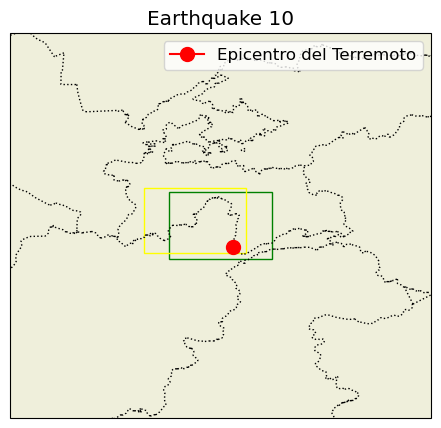

In [45]:
#Earthquake index 10

# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = [(69.40976, 38.217232), (72.276085, 38.613117), (72.618683, 36.93565), (69.818718, 36.538315)]
bbox_coords2 = [(71.423782, 36.721191), (68.622314, 37.116951), (68.952934, 38.736588), (71.818748, 38.342243)]
# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])


xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])


# Coordinate dell'epicentro del terremoto
epicenter_lat = final_df['latitude'].iloc[9]
epicenter_lon = final_df['longitude'].iloc[9]
#print(epicenter_lat, epicenter_lon)

# Creare una figura e una proiezione cartografica
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Aggiungere caratteristiche della terra
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Aggiungere il rettangolo del bbox
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1,
                 linewidth=1, edgecolor='green', facecolor='none')

# Aggiungere il rettangolo del bbox
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2,
                 linewidth=1, edgecolor='yellow', facecolor='none')


ax.add_patch(rect1)
ax.add_patch(rect2)

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
#ax.set_extent([xmin1 - 50, xmax1 + 50, ymin1 - 50, ymax1 + 50], crs=ccrs.PlateCarree())
ax.set_extent([xmin1 - 5, xmax1 + 5, ymin1 - 5, ymax1 + 5], crs=ccrs.PlateCarree())


# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

#add legend
plt.legend()
plt.title('Earthquake 10')

# Visualizzare la mappa
plt.show()

In [52]:
#Interferogramma 10
import zipfile
import os

def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)

# Example paths
zip_path_pre = './Images/Image10/SAR/SLC/2018/05/05/S1A_IW_SLC__1SDV_20180505T131356_20180505T131424_021770_02590E_A276.zip'
zip_path_post = './Images/Image10/SAR/SLC/2018/05/11/S1A_IW_SLC__1SDV_20180511T012223_20180511T012250_021850_025BAF_5B37.zip'

# Define extraction directories
extract_to_pre = './Images/Image10/SAR/SLC/2018/05/05/'
extract_to_post = './Images/Image10/SAR/SLC/2018/05/11/'

# Extract the content
extract_zip(zip_path_pre, extract_to_pre)
extract_zip(zip_path_post, extract_to_post)


In [57]:
import os
import glob

# Function to find .tiff files in the .SAFE directory
def find_tiff_files(safe_dir):
    # Search for all .tiff files in the 'measurement' directory
    tiff_files = glob.glob(os.path.join(safe_dir, 'measurement', '*.tiff'))
    return tiff_files

# Path to the extracted .SAFE directories
safe_dir_pre = './Images/Image10/SAR/SLC/2018/05/05/S1A_IW_SLC__1SDV_20180505T131356_20180505T131424_021770_02590E_A276.SAFE'
safe_dir_post = './Images/Image10/SAR/SLC/2018/05/11/S1A_IW_SLC__1SDV_20180511T012223_20180511T012250_021850_025BAF_5B37.SAFE'

# Find the .tiff files
pre_tiff_files = find_tiff_files(safe_dir_pre)
post_tiff_files = find_tiff_files(safe_dir_post)

# Check if any .tiff files were found
if not pre_tiff_files:
    raise FileNotFoundError("No .tiff files found in the pre-earthquake .SAFE directory")

if not post_tiff_files:
    raise FileNotFoundError("No .tiff files found in the post-earthquake .SAFE directory")

# Assuming we're interested in the first file (usually VV or VH polarization)
pre_tiff_path = pre_tiff_files[0]
post_tiff_path = post_tiff_files[0]

print("Pre-earthquake TIFF file:", pre_tiff_path)
print("Post-earthquake TIFF file:", post_tiff_path)


Pre-earthquake TIFF file: ./Images/Image10/SAR/SLC/2018/05/05/S1A_IW_SLC__1SDV_20180505T131356_20180505T131424_021770_02590E_A276.SAFE/measurement/s1a-iw3-slc-vh-20180505t131357-20180505t131422-021770-02590e-003.tiff
Post-earthquake TIFF file: ./Images/Image10/SAR/SLC/2018/05/11/S1A_IW_SLC__1SDV_20180511T012223_20180511T012250_021850_025BAF_5B37.SAFE/measurement/s1a-iw1-slc-vh-20180511t012225-20180511t012250-021850-025baf-001.tiff


In [59]:
import rasterio

# Load the pre- and post-earthquake images
with rasterio.open(pre_tiff_path) as pre_src:
    pre_image = pre_src.read(1)  # Read the first band (assuming VV or VH)

with rasterio.open(post_tiff_path) as post_src:
    post_image = post_src.read(1)  # Read the first band

print(pre_image.shape)  # This should print the shape of the loaded image (e.g., (rows, cols))
print(post_image.shape)  # Same shape as pre_image


(13608, 24446)
(13482, 21577)


In [63]:
# Get the dimensions of the images
rows_pre, cols_pre = pre_image.shape
rows_post, cols_post = post_image.shape

# Find the minimum dimensions
min_rows = min(rows_pre, rows_post)
min_cols = min(cols_pre, cols_post)

# Crop both images to the smallest common area
pre_image_cropped = pre_image[:min_rows, :min_cols]
post_image_cropped = post_image[:min_rows, :min_cols]

# Now, compute the interferogram
interferogram = np.angle(post_image_cropped * np.conj(pre_image_cropped))

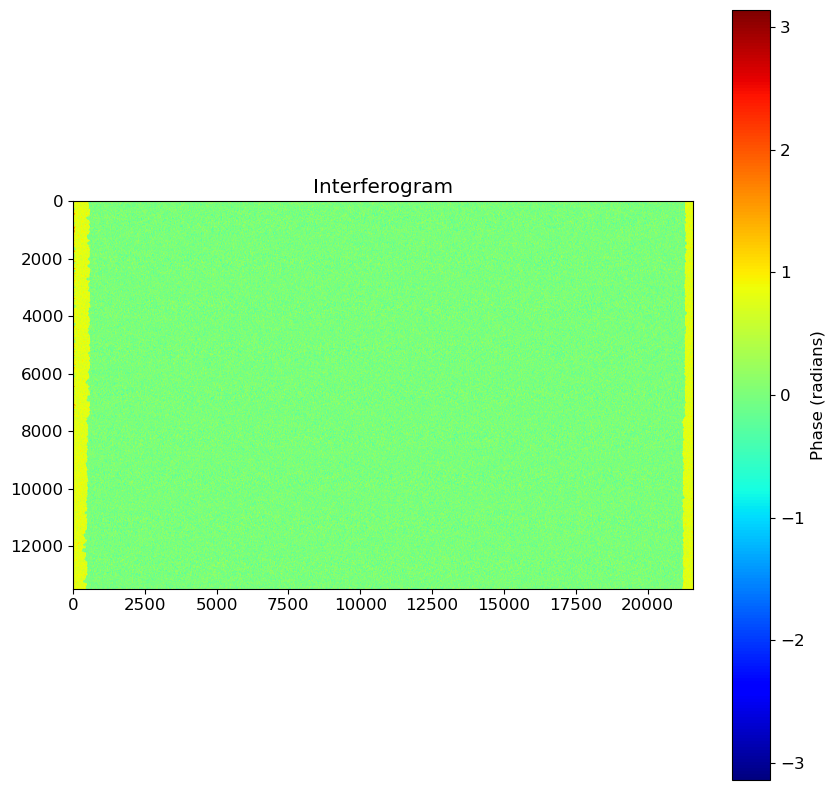

INFO: org.hsqldb.persist.Logger: Database closed


In [65]:
import numpy as np
import rasterio
from rasterio.enums import Resampling
from scipy.ndimage import zoom

def resample_image(src_image_path, target_shape, resampling_method=Resampling.bilinear):
    with rasterio.open(src_image_path) as src:
        src_data = src.read(1)  # Read the first band
        
        # Calculate the scaling factors
        src_height, src_width = src_data.shape
        target_height, target_width = target_shape
        
        # Calculate the scaling factors
        scale_y = src_height / target_height
        scale_x = src_width / target_width
        
        # Resample the image
        resampled_data = zoom(src_data, (1/scale_y, 1/scale_x), order=3)
        
        # Crop or pad to match target shape exactly if necessary
        if resampled_data.shape[0] > target_height:
            resampled_data = resampled_data[:target_height, :]
        if resampled_data.shape[1] > target_width:
            resampled_data = resampled_data[:, :target_width]
        
        return resampled_data

# Define target shape (based on the smaller image dimensions)
target_shape = (min(rows_pre, rows_post), min(cols_pre, cols_post))

# Resample both images to the target shape
pre_resampled = resample_image(pre_tiff_path, target_shape)
post_resampled = resample_image(post_tiff_path, target_shape)

# Convert to complex arrays if necessary
# Assuming you have loaded real and imaginary parts separately:
# pre_image = pre_image_real + 1j * pre_image_imag
# post_image = post_image_real + 1j * post_image_imag

# Compute the interferogram
interferogram = np.angle(post_resampled * np.conj(pre_resampled))

# Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.imshow(interferogram, cmap='jet')
plt.colorbar(label='Phase (radians)')
plt.title('Interferogram')
plt.show()


In [ ]:
#10

In [ ]:
from snapista import Graph, Operator
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

# Initialize the graph
graph = Graph()

# Define paths to your Sentinel-1 products
product1 = 'Images/Image10/SAR/SLC/2018/05/05/S1A_IW_SLC__1SDV_20180505T131356_20180505T131424_021770_02590E_A276.zip'
product2 = 'Images/Image10/SAR/SLC/2018/05/11/S1A_IW_SLC__1SDV_20180511T012223_20180511T012250_021850_025BAF_5B37.zip'

# Define paths to your orbit files (make sure these are correct)
orbit_file1 = '/home/ebuccoliero/miniforge3/envs/snappp/snap/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2018/01/S1A_OPER_AUX_POEORB_OPOD_20180114T225942_20180115T005942.EOF'
orbit_file2 = '/home/ebuccoliero/miniforge3/envs/snappp/snap/.snap/auxdata/Orbits/Sentinel-1/POEORB/S1A/2018/01/S1A_OPER_AUX_POEORB_OPOD_20180126T225942_20180127T005942.EOF'

# Add nodes to the graph
graph.add_node(Operator('Read', file=product1), node_id='Read1')
graph.add_node(Operator('Read', file=product2), node_id='Read2')

# Apply orbit files (using manually specified orbit file paths)
graph.add_node(Operator('Apply-Orbit-File', parameters={'orbitType': 'Sentinel Precise (Manual)', 'orbitFile': orbit_file1}), node_id='Apply-Orbit-File1', source='Read1')
graph.add_node(Operator('Apply-Orbit-File', parameters={'orbitType': 'Sentinel Precise (Manual)', 'orbitFile': orbit_file2}), node_id='Apply-Orbit-File2', source='Read2')

graph.add_node(Operator('Back-Geocoding'), node_id='Back-Geocoding', source=['Apply-Orbit-File1', 'Apply-Orbit-File2'])

graph.add_node(Operator('Interferogram'), node_id='Interferogram', source='Back-Geocoding')

graph.add_node(Operator('TopoPhaseRemoval'), node_id='TopoPhaseRemoval', source='Interferogram')

graph.add_node(Operator('GoldsteinPhaseFiltering'), node_id='GoldsteinPhaseFiltering', source='TopoPhaseRemoval')

graph.add_node(Operator('Terrain-Correction'), node_id='Terrain-Correction', source='GoldsteinPhaseFiltering')

# Define the parameters for the Write node
write_params = {
    'file': 'Images/Image3/interferogram.dim',
    'formatName': 'BEAM-DIMAP'
}

graph.add_node(Operator('Write', **write_params), node_id='Write', source='Terrain-Correction')

# Run the graph
try:
    graph.run()
    print("Graph execution completed successfully.")

    # Visualization using matplotlib
    with rasterio.open('Images/Image3/interferogram.data/phase.img') as src:
        fig, ax = plt.subplots(figsize=(10, 10))
        show(src, ax=ax, cmap='gray')
        plt.title('Interferogram Phase')
        plt.show()
except Exception as e:
    print(f"Graph execution failed: {e}")


In [ ]:
name= 'Images/Image11/SAR/SLC/2018/05/04/S1A_IW_SLC__1SDV_20180504T212317_20180504T212345_021760_0258C7_2816.zip'
scene11_1 = identify(name)
print(scene11_1)

In [ ]:
name= 'Images/Image11/SAR/SLC/2018/05/16/S1A_IW_SLC__1SDV_20180516T212318_20180516T212345_021935_025E56_9F92.zip'
scene11_2 = identify(name)
print(scene11_2)

In [ ]:
#Earthquake index 11

# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = [(127.125206, 8.549189), (124.867195, 9.003301), (125.202263, 10.686872), (127.471863, 10.237293)]
bbox_coords2 = [(127.124886, 8.549896), (124.866867, 9.003989), (125.201851, 10.687189), (127.471458, 10.237628)]
# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])


xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])


# Coordinate dell'epicentro del terremoto
epicenter_lat = final_df['latitude'].iloc[10]
epicenter_lon = final_df['longitude'].iloc[10]
#print(epicenter_lat, epicenter_lon)

# Creare una figura e una proiezione cartografica
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Aggiungere caratteristiche della terra
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Aggiungere il rettangolo del bbox
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1,
                 linewidth=1, edgecolor='green', facecolor='none')

# Aggiungere il rettangolo del bbox
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2,
                 linewidth=1, edgecolor='yellow', facecolor='none')


ax.add_patch(rect1)
ax.add_patch(rect2)

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 0.2, xmax1 + 0.2, ymin1 - 0.2, ymax1 + 0.2], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

#add legend
plt.legend()
plt.title('Earthquake 11')

# Visualizzare la mappa
plt.show()


In [ ]:
name= 'Images/Image12/SAR/SLC/2018/05/10/S1A_IW_SLC__1SDV_20180510T202448_20180510T202518_021847_025B95_6E2B.zip'
scene12_1 = identify(name)
print(scene12_1)

In [ ]:
name= 'Images/Image12/SAR/SLC/2018/05/22/S1A_IW_SLC__1SDV_20180522T202449_20180522T202518_022022_026128_D9B2.zip'
scene12_2 = identify(name)
print(scene12_2)

In [ ]:
#Earthquake index 12

# Coordinate del bounding box (xmin, ymin, xmax, ymax)
bbox_coords1 = [(146.677017, 41.444508), (143.694778, 41.835011), (144.078262, 43.625229), (147.150162, 43.235115)]
bbox_coords2 = [(146.677322, 41.445889), (143.695099, 41.836365), (144.078461, 43.625973), (147.150299, 43.235882)]
# Trovare i valori minimi e massimi per xmin, ymin, xmax e ymax
xmin1 = min([coord[0] for coord in bbox_coords1])
xmax1 = max([coord[0] for coord in bbox_coords1])
ymin1 = min([coord[1] for coord in bbox_coords1])
ymax1 = max([coord[1] for coord in bbox_coords1])


xmin2 = min([coord[0] for coord in bbox_coords2])
xmax2 = max([coord[0] for coord in bbox_coords2])
ymin2 = min([coord[1] for coord in bbox_coords2])
ymax2 = max([coord[1] for coord in bbox_coords2])


# Coordinate dell'epicentro del terremoto
epicenter_lat = final_df['latitude'].iloc[11]
epicenter_lon = final_df['longitude'].iloc[11]
#print(epicenter_lat, epicenter_lon)

# Creare una figura e una proiezione cartografica
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Aggiungere caratteristiche della terra
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

# Aggiungere il rettangolo del bbox
rect1 = Rectangle((xmin1, ymin1), xmax1 - xmin1, ymax1 - ymin1,
                 linewidth=1, edgecolor='green', facecolor='none')

# Aggiungere il rettangolo del bbox
rect2 = Rectangle((xmin2, ymin2), xmax2 - xmin2, ymax2 - ymin2,
                 linewidth=1, edgecolor='yellow', facecolor='none')


ax.add_patch(rect1)
ax.add_patch(rect2)

# Aggiungere il punto dell'epicentro del terremoto
ax.plot(epicenter_lon, epicenter_lat, marker='o', color='red', markersize=10, label='Epicentro del Terremoto')

# Impostare i limiti della mappa per centrare e zoomare sull'area del bounding box
ax.set_extent([xmin1 - 0.2, xmax1 + 0.2, ymin1 - 0.2, ymax1 + 0.2], crs=ccrs.PlateCarree())

# Aggiungere le linee della griglia
#ax.gridlines(draw_labels=True)

#add legend
plt.legend()
plt.title('Earthquake 12')

# Visualizzare la mappa
plt.show()
